In [13]:
import subprocess
from multiprocessing import Pool,cpu_count
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
import fileinput as fi

%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

In [2]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

# Initial RSnostim equilibrium check

(480, 510)

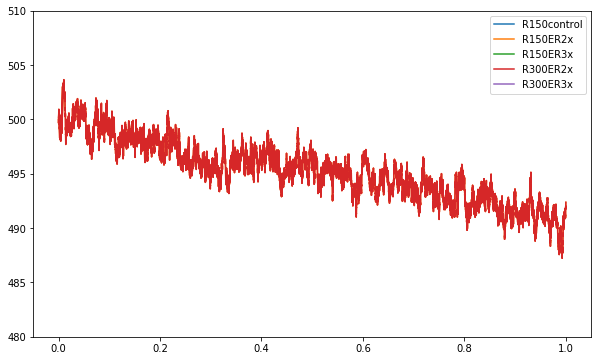

In [33]:
sims=["R150control","R150ER2x","R150ER3x","R300ER2x","R300ER3x"]
data_loc="/data/kabir/output/ppf/"
sim_type="RSnostim"

data_type=["ca.dat","pmca&leak_ca_flux.dat","serca_ca_flux.dat"]

plt.figure(figsize=(10,6))
for s in sims:
    data_folder=data_loc+s+'/'+sim_type
    data_file=data_folder+"/s_00001/dat/"+data_type[0]
    ca_dat=np.loadtxt(data_file)
    #print(ca_dat)
    ydata=ca_dat.T[3]*1e15/N_avo/vol_er*1e6
    #ydata=ca_dat.T[2]-ca_dat.T[1]
    xdata=ca_dat.T[0]
    plt.plot(xdata,ydata,label=s)
plt.legend()


plt.ylim((480,510))

# Search and Replace in files

In [67]:
dataloc="/home/kabir/Project/tripartiteSynapse/mcell/R300ER2x/"
files=os.listdir(dataloc)
RSI_files=[]
for f in files:
    if "RSI" in f:
        RSI_files.append(f)
#RSI_files

In [68]:
for fn in RSI_files:
    with fi.FileInput(dataloc+fn,inplace=True, backup='.bak') as f:
        for line in f:
            print(line.replace('"ppf/"','"ppf/R300ER2x/"'), end='')

# kleak conversion to mcell

In [69]:
#from S Bandara et al 2013
J=0.07*250 #uM/s
J/=1e15/N_avo/vol_er*1e6
print("Ca Flux in ions/sec = ",J)

p=[2.1675959461586873, 6.214988757731395]
kleak=(J-p[1])/p[0]
print("Predicted kleak = ",kleak)

Ca Flux in ions/sec =  411.01111642500007
Predicted kleak =  186.74888573427603


# creating run.sh file

In [53]:
def seed_num(fname):
    vdcc_num=int(fname.split('V')[1].replace('.mdl',''))
    if vdcc_num>=110 and vdcc_num<=160:
        return 1000
    elif vdcc_num>=90 and vdcc_num<=100:
        return 2000
    elif vdcc_num>=70 and vdcc_num<=80:
        return 3000
    elif vdcc_num>=40 and vdcc_num<=60:
        return 5000
    else:
        return 10

In [151]:
a="""for name in fnames:
    input_loc=script_folder+'/'+name.replace('V90','V80')
    output_loc=script_folder+'/'+name
    with open(input_loc,'r') as infile:
        lines=infile.readlines()
    
    lines=[line.replace("VDCC_number_presynaptic = 80","VDCC_number_presynaptic = 90") for line in lines]
        
    with open(output_loc,'w') as outfile:
        outfile.writelines(lines)
#"""            

In [198]:
#VDCC range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[0]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=list(range(60,101,20))
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
#fnames=["RSI20V90.mdl","RSI30V90.mdl","RSI40V90.mdl"]
print(fnames)
#seed_num=1000

/home/kabir/Project/tripartiteSynapse/mcell/R150control
isi = [20] 
vdcc = [60, 80, 100]
['RSI20V60.mdl', 'RSI20V80.mdl', 'RSI20V100.mdl']


In [206]:
#ISI range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[4]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=list(range(20,101,20))
VDCC=[90]
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
#fnames=["RSI20V90.mdl","RSI30V90.mdl","RSI40V90.mdl"]
print(fnames)
#seed_num=1000

#write run.sh
with open(script_folder+'/run.sh','w') as f:
    for name in fnames:
            loc=script_folder+'/'+name
            f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(seed_num(name))+"/' pbs.py\n")
            f.write("qsub -N "+name.replace(".mdl",sim_type).replace("RSI",'I')+" -v I='"+loc.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

#sync script files to cluster
p=subprocess.call(["rsync","-arhP",script_folder,"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/mcell/"])

/home/kabir/Project/tripartiteSynapse/mcell/R300ER3x
isi = [20, 40, 60, 80, 100] 
vdcc = [90]
['RSI20V90.mdl', 'RSI40V90.mdl', 'RSI60V90.mdl', 'RSI80V90.mdl', 'RSI100V90.mdl']


In [280]:
outfolder='AD/RSI40V90'

In [41]:
outfolder='AD'#RSI40V90'

In [42]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

In [156]:
outfolder='R150control'#RSI40V90'

In [157]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

RSI100V90.mdl
RSI40V90.mdl
RSI60V90.mdl
RSI80V90.mdl
RSI20V90.mdl

Calculating Average of
Calculating Average of
Calculating Average of /dat/ca.dat
 /dat/ca.dat
 /dat/ca.dat

Calculating Average of
Calculating Average of /dat/ca.dat
 /dat/ca.dat
seeds:  2000
seeds:  2000
seeds:  2000
seeds:  2000
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150control/RSI40V90/ca.dat
Calculating Calcium Concentration...
Writing Ca Conc. to file:/CaConc
isi:  40 
vdcc:  90
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150control/RSI20V90/ca.dat
Calculating Calcium Concentration...
Writing Ca Conc. to file:/CaConc
isi:  20 
vdcc:  90
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150control/RSI60V90/ca.dat
Calculating Calcium Concentration...
Writing Ca Conc. to file:/CaConc
isi:  60 
vdcc:  90
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150control/RSI8

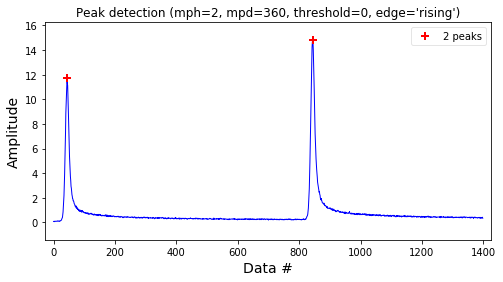

isi:  40 
vdcc:  90
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 4.22000000e-02
 1.47788350e+01 2.58498470e-02]
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 4.22000000e-02
 1.47788350e+01 2.58498470e-02 4.00000000e+01 9.00000000e+01]
resampling: 900
resampling: 700
resampling: 700
resampling: 1000
Vesicle release stats:
 [0.17100000000000032, 0.0083190744677518, 0.38795099999999993, 0.010385643889523666, 2.2741160797231323, 0.12674565627362003, 0.6062826537006967, 0.011515071848745107, 0.39371734629930205, 0.011515071848745107, 0.6399777465820919, 0.02549306571478832, 0.36002225341790806, 0.02549306571478834, 60.0, 90.0]


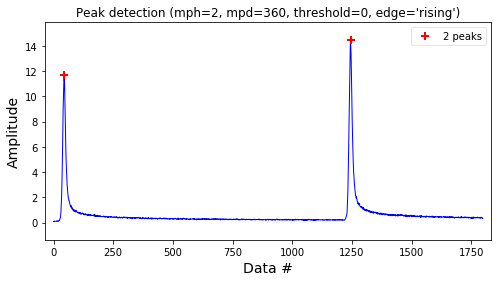

isi:  60 
vdcc:  90
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 6.22000000e-02
 1.44178270e+01 2.44770690e-02]
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 6.22000000e-02
 1.44178270e+01 2.44770690e-02 6.00000000e+01 9.00000000e+01]
resampling: 1000
Vesicle release stats:
 [0.17084850000000026, 0.008263431354467709, 0.3114700000000001, 0.010169886921691903, 1.8273557490210182, 0.10667275409516658, 0.6853448331052048, 0.01138885925422843, 0.3146551668947947, 0.011388859254228431, 0.7040000974002669, 0.02472421965932456, 0.29599990259973363, 0.024724219659324555, 100.0, 90.0]


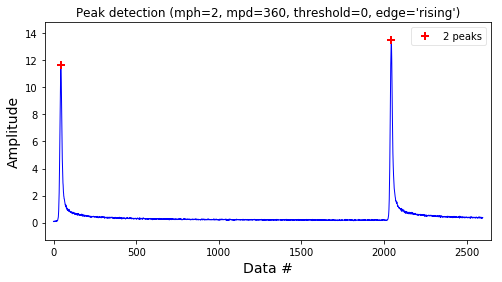

isi:  100 
vdcc:  90
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 1.02250000e-01
 1.34755400e+01 2.30475214e-02]
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 1.02250000e-01
 1.34755400e+01 2.30475214e-02 1.00000000e+02 9.00000000e+01]
resampling: 800
resampling: 800
resampling: 900
resampling: 900
resampling: 1000
Vesicle release stats:
 [0.17161350000000028, 0.008503932487384862, 0.36783749999999976, 0.01074459602544464, 2.1487626909979, 0.12514023266994742, 0.6275380096690548, 0.01177070850164628, 0.37246199033094535, 0.011770708501646274, 0.6544672168303592, 0.024794934128752378, 0.3455327831696407, 0.02479493412875238, 80.0, 90.0]


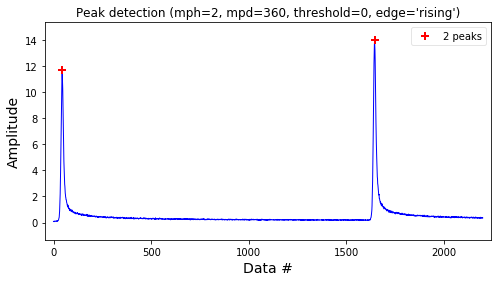

isi:  80 
vdcc:  90
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 8.22000000e-02
 1.39766290e+01 2.37346989e-02]
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86398489e-02 8.22000000e-02
 1.39766290e+01 2.37346989e-02 8.00000000e+01 9.00000000e+01]
resampling: 1000
Vesicle release stats:
 [0.17421050000000032, 0.008142661711627214, 0.5624369999999992, 0.010457941049747779, 3.2357915859508584, 0.1675570406647635, 0.42529889451937275, 0.011418241000312013, 0.574701105480627, 0.011418241000312008, 0.49572668338503606, 0.027343582526782147, 0.504273316614964, 0.02734358252678215, 20.0, 90.0]


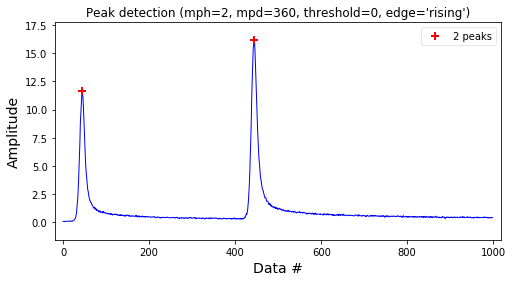

isi:  20 
vdcc:  90
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86478956e-02 2.22000000e-02
 1.61323260e+01 2.85700206e-02]
Ca stats:
 [2.20000000e-03 1.16938160e+01 1.86478956e-02 2.22000000e-02
 1.61323260e+01 2.85700206e-02 2.00000000e+01 9.00000000e+01]


[None, None, None, None, None]

In [207]:
%run analysis.ipynb
p=Pool(ncores)
#print(fnames)
p.starmap(all_analysis,product(fnames,sims[0:1]))
#all_analysis(fnames[-1])


In [204]:
def all_analysis(name,sim):
    print(name)
    dataDirName = name.replace(".mdl","")
    dataType = "ppf/"+sim+"/"
    
    M=analysis(dataDirName,dataType)

    M.avg_dat(inFile="/dat/ca.dat", outFile="/ca.dat")
    M.conc_calc(inFile="/ca.dat", outFile="/CaConc")

    isi = int(M.dataDirName.split("I")[1].split("V")[0])
    vdcc = int(M.dataDirName.split("V")[1])
    print('isi: ', isi, '\nvdcc: ', vdcc)

    M.relppf(isi, vdcc, resample=1000)

    M.caStat(showFig=True)

In [208]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
result={}
for sim_type in sims[0:1]:
    result[sim_type]={}
    for name in fnames:
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'result'
        if os.path.isfile(loc+'.dat'):
            os.rename(loc+'.dat',loc)
        with open(loc,'r') as f:
            l=f.readlines()
            result[sim_type][name]=[float(a) for a in l[2].replace('\n','').split('\t')]
#/home/kabir/Project/tripartiteSynapse/results/ppf/R150ER2x/RSI20V120

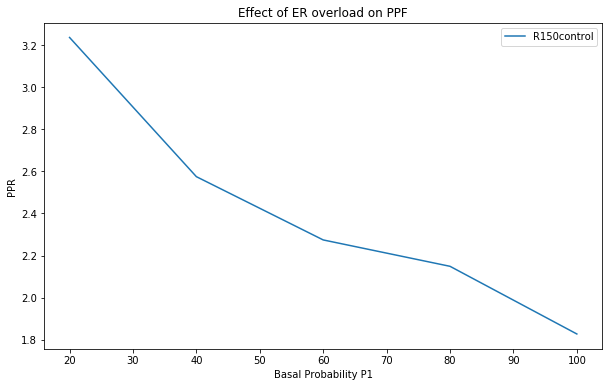

In [211]:
plt.figure(figsize=(10,6))
for sim_type in sims[0:1]:
    #print(result[sim_type])
    res=result[sim_type]
    xdata=[res[name][-2] for name in fnames]
    ydata=[res[name][4] for name in fnames]
    #print(ydata)
    plt.plot(xdata,ydata,label=sim_type)
plt.xlabel("Basal Probability P1")
plt.ylabel("PPR")
plt.title("Effect of ER overload on PPF")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ppr.pdf")

In [281]:
#combine glutamate release data for each seed
data_loc="/data/kabir/output/ppf/"+outfolder+'/'
#get seed folders
seed_folders=os.listdir(data_loc)

count=0
if "Average" in seed_folders:
    seed_folders.remove("Average")
for s in seed_folders:
    s=data_loc+s+"/dat/"
    file_names=os.listdir(s)
    output=[]
    for f_name in file_names:
        if 'vdcc.' in f_name:
            with open(s+f_name,'r') as f:
                output=output+f.readlines()
    with open(s+'rel.dat','w') as f:
        f.writelines(output)
    count+=len(output)

count/500

0.67

In [4]:
%run testLocal.py norm/RSI20V90
norm_ppf=ppf(resample=10)
%run testLocal.py AD/RSI20V90
AD_ppf=ppf(resample=10)
print("normal PPR = ",norm_ppf[4])
print("AD PPR     = ",AD_ppf[4])

dataPath :  /data/kabir/output/ppf/norm/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/norm/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.0382, 0.008072174428244226, 0.34719999999999995, 0.02584879107424562, 9.611293613731359, 2.5516180832777358, 20.0, 90.0]
dataPath :  /data/kabir/output/ppf/AD/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.09159999999999999, 0.016044936896105262, 0.49840000000000007, 0.020293841430345325, 5.623162580693527, 1.070975085559397, 20.0, 90.0]
normal PPR =  9.611293613731359
AD PPR     =  5.623162580693527


In [9]:
%run testLocal.py AD/RSI40V90

dataPath :  /data/kabir/output/ppf/AD/RSI40V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI40V90


In [10]:
AD_ppf=ppf(resample=10)

isi:  40 vdcc:  90
seeds:  500
[0.0922, 0.014462364951832738, 0.403, 0.01782694589659148, 4.509857438817555, 0.8958789564708997, 40.0, 90.0]


In [261]:
%run averaging1.ipynb

averager("/data/kabir/output/ppf/norm/RSI40V90","ca.dat",[2,3])

In [208]:
outfolder='norm/RSI20V40'
data_file="/data/kabir/output/ppf/norm/RSI20V40/Average/ca.dat"
data1=np.loadtxt(data_file)

outfolder='AD/RSI40V90/'
data_file="/data/kabir/output/ppf/AD/RSI40V90/Average/ca.dat"
data2=np.loadtxt(data_file)

In [3]:
#plt.plot(data1.T[0,:],data1.T[1,:],label='normal')#*1e15/N_avo/vol_er*1e6)
plt.plot(data2.T[0,:],data2.T[1,:],label='AD')#*1e15/N_avo/vol_er*1e6)
plt.legend()

NameError: name 'plt' is not defined

In [11]:
data1.T[:,0]

array([   0.,    0.,   57., 5872.])